In [18]:
import rasterio
import rasterio.features
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.vrt import WarpedVRT
from shapely.geometry import shape, mapping

import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

import geopandas as gpd 
import numpy as np

import os

# Load City 

In [3]:
city_path = f"../SSANTO Data/Boundary/zurich_boundaries.shp"

In [4]:
base_dir = f"GR-Data/"
old_dir = os.path.join(os.getcwd(), "01_Value-scaled_Maps/")
new_dir = os.path.join(os.getcwd(), "02_Value-scaled_Maps/")


value_scale_files = os.listdir(base_dir)
value_scale_files.sort()

objective_set = {title[:3] for title in value_scale_files}
print(value_scale_files)


['1-1_1234_Slope_vs.tif', '1-3_all_Building_Age_vs.tif', '1-6_all_Dist_Streams_vs.tif', '1-9_all_Flow_Accumulation_vs.tif', '2-1_all_Green_Votes_vs.tif', '3-1_all_Drainage_Distance_vs.tif', '3-2_1234_Dist_Streets_vs.tif', '3-3_all_Dist_Heritage_vs.tif', '4-1_all_Irrigation_Demand_vs.tif', '5-1_all_Imperviousness_vs.tif', '5-2_all_Heat_vulnearability_vs.tif', '6-1_all_Visibility_vs.tif', '6-2_all_Recreational_vs.tif', '7-1_all_NDVI_vs.tif', '7-2_all_Func_Connectivity_vs.tif']


In [7]:
# Load the city of zurich
zurich_file  = "Boundary/zurich_boundaries.gpkg"

city_gdf = gpd.read_file(zurich_file)
# Set the CRS to CH1903+ / LV95 (Zurich region) –
city_gdf.set_crs("EPSG:2056", inplace=True, allow_override=True)

name  canton nuts2         region  \
0  Zürich  Zürich  CH04  Zurich-Geneva   

                                            geometry  
0  POLYGON Z ((2685056.895 1244517.809 405.850, 2...

### Change resolution of all files

In [43]:
TARGET_RESOLUTION = 30
target_crs = rasterio.crs.CRS.from_epsg(2056)

old_dir = os.path.join(os.getcwd(), "01_Value-scaled_Maps/")
new_dir = os.path.join(os.getcwd(), "02_Value-scaled_Maps/")
os.makedirs(new_dir, exist_ok=True)

for fname in value_scale_files:
    input_file = os.path.join(old_dir, fname)
    output_file = os.path.join(new_dir, fname)

    with rasterio.open(input_file) as src:
        # Force the CRS to EPSG:2056 regardless of what it currently is
        # by creating a new dataset in memory with the desired CRS.
        meta = src.meta.copy()
        meta.update({'crs': target_crs})

        # Compute new dimensions and transform for the target resolution
        left, bottom, right, top = src.bounds
        width = int((right - left) / TARGET_RESOLUTION)
        height = int((top - bottom) / TARGET_RESOLUTION)
        transform = rasterio.transform.from_bounds(left, bottom, right, top, width, height)

        # Use WarpedVRT to "resample" the data at the new resolution
        # but with the same CRS. Since src_crs and dst_crs match,
        # this doesn't require a coordinate operation, just resampling.
        vrt_options = {
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height,
            'resampling': Resampling.bilinear
        }

        with WarpedVRT(src, **vrt_options) as vrt:
            data = vrt.read()

            # Update metadata for output
            out_meta = vrt.meta.copy()
            out_meta.update({
                'driver': 'GTiff',
                'compress': 'lzw',
                'tiled': True
            })

            with rasterio.open(output_file, 'w', **out_meta) as dst:
                dst.write(data)
    print(f"{fname} has been resampled to {TARGET_RESOLUTION}m resolution with EPSG:2056.")

1-1_1234_Slope_vs.tif has been resampled to 30m resolution with EPSG:2056.
1-1_5_Slope_vs.tif has been resampled to 30m resolution with EPSG:2056.


CPLE_NotSupportedError: Cannot find coordinate operations from '{   "$schema": "https://proj.org/schemas/v0.7/projjson.schema.json",   "type": "EngineeringCRS",   "name": "CH1903+ / LV95",   "datum": {     "name": "Unknown engineering datum"   },   "coordinate_system": {     "subtype": "Cartesian",     "axis": [       {         "name": "Easting",         "abbreviation": "",         "direction": "east",         "unit": "metre"       },       {         "name": "Northing",         "abbreviation": "",         "direction": "north",         "unit": "metre"       }     ]   } }' to 'EPSG:2056'

In [8]:
# Define the target CRS explicitly
target_crs = rasterio.crs.CRS.from_epsg(2056)
# new_dir = os.path.join(os.getcwd(), "02_Value-scaled_Maps/")
em_dir  = "emissions"
# value_scale_files = os.listdir(em_dir)
value_scale_files = ["res_ind_high_res.tif"]


# Target resolution
TARGET_RESOLUTION = 30

files_missing = []

# Direct computation of new resolution without `calculate_default_transform`
def compute_new_transform(src, target_resolution):
    left, bottom, right, top = src.bounds
    width = int((right - left) / target_resolution)
    height = int((top - bottom) / target_resolution)
    transform = rasterio.transform.from_bounds(left, bottom, right, top, width, height)
    return transform, width, height

# Process each file
for i in range(len(value_scale_files)):
    input_file = os.path.join(em_dir, value_scale_files[i])
    output_file = os.path.join(em_dir, value_scale_files[i]+"_resampled.tif")

    with rasterio.open(input_file) as src:
        # print("Sum of values in the raster: ", np.nansum(src.read(1)))

        if src.crs is None:
            print(f"File {value_scale_files[i]} has no CRS. Assigning EPSG:2056.")
            src_crs = target_crs
        elif "LOCAL_CS" in src.crs.to_string():
            print(f"File {value_scale_files[i]} has LOCAL_CS. Skipping.")
            files_missing.append(value_scale_files[i])
            continue
        else:
            src_crs = src.crs
            print(f"File {value_scale_files[i]} CRS: {src_crs}")

        # Compute the new transform and dimensions directly
        transform, width, height = compute_new_transform(src, TARGET_RESOLUTION)

        # Update metadata
        metadata = src.meta.copy()
        metadata.update({
            'crs': target_crs,  # Force EPSG:2056
            'transform': transform,
            'width': width,
            'height': height,
            'compress': 'lzw',
            'driver': 'GTiff',
            'tiled': True,
        })

        # Make sure all values are within the suitability range (0,100)
        raster_data = src.read(1)
        # raster_safe = np.where((raster_data > threshold) | (raster_data < 1), 0, raster_data)

        # Perform the resampling (no CRS transformation required, same CRS)
        with rasterio.open(output_file, 'w', **metadata) as dst:
            for band in range(1, src.count + 1):
                reproject(
                    source=raster_data,
                    destination=rasterio.band(dst, band),
                    src_transform=src.transform,
                    src_crs=src_crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.bilinear
                )
        print(f"Resampled {value_scale_files[i]} to {TARGET_RESOLUTION}m resolution.")

File res_ind_high_res.tif CRS: EPSG:2056
Resampled res_ind_high_res.tif to 30m resolution.


Resolution: 30.022321428571427 x 30.02358490566038


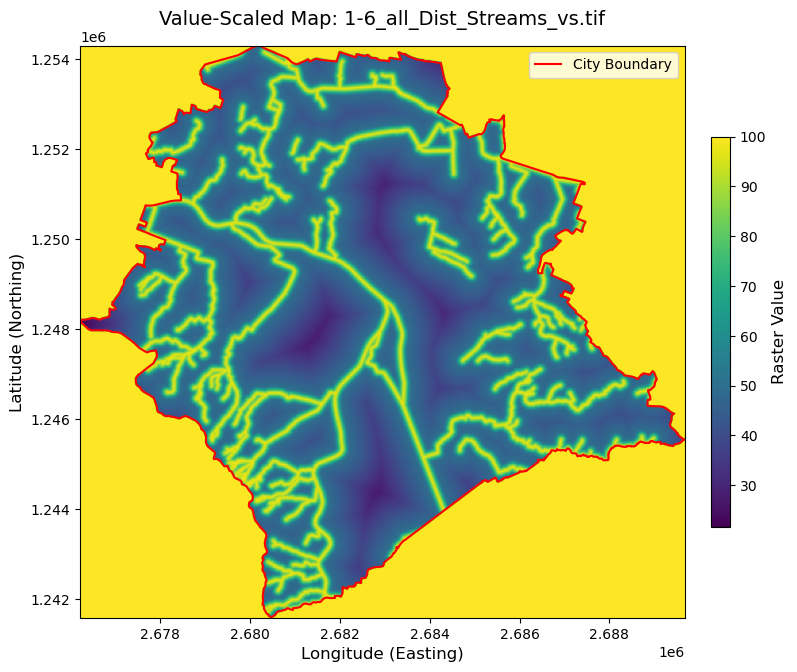

Raster CRS: EPSG:2056
Unique values in raster: [ 21.677294  22.283224  22.473928 ...  99.99995   99.999954 100.      ]


In [8]:
file_num = 2
# Plotting the raster with better formatting
with rasterio.open(new_dir + value_scale_files[file_num]) as src:
# with rasterio.open(new_path) as src:
    raster_crs = src.crs
    raster_meta = src.meta.copy()
    raster_data = src.read(1)

    # Define raster extent
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]
    res_x, res_y = src.res  # Alternatively: src.transform[0], -src.transform[4]
    print(f"Resolution: {res_x} x {res_y}")
    
    # Reproject city_gdf to match raster CRS
    # city_gdf.to_crs(raster_crs, inplace=True)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 7))

    # Set a threshold to mask out high values
    threshold = 100  # Define your threshold here
    raster_safe = np.where((raster_data > threshold) | (raster_data < 1), 0, raster_data)
    
    # Plot the raster data
    im = ax.imshow(raster_safe, cmap='viridis', extent=extent, origin='upper')
    city_gdf.boundary.plot(ax=ax, color='red', linewidth=1.5, label="City Boundary")
    
    # Customize plot
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Raster Value', fontsize=12)
    ax.set_title(f"Value-Scaled Map: {value_scale_files[file_num]}", fontsize=14, pad=15)
    ax.set_xlabel("Longitude (Easting)", fontsize=12)
    ax.set_ylabel("Latitude (Northing)", fontsize=12)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    print(f"Raster CRS: {raster_crs}")

    print("Unique values in raster:", np.unique(raster_data))



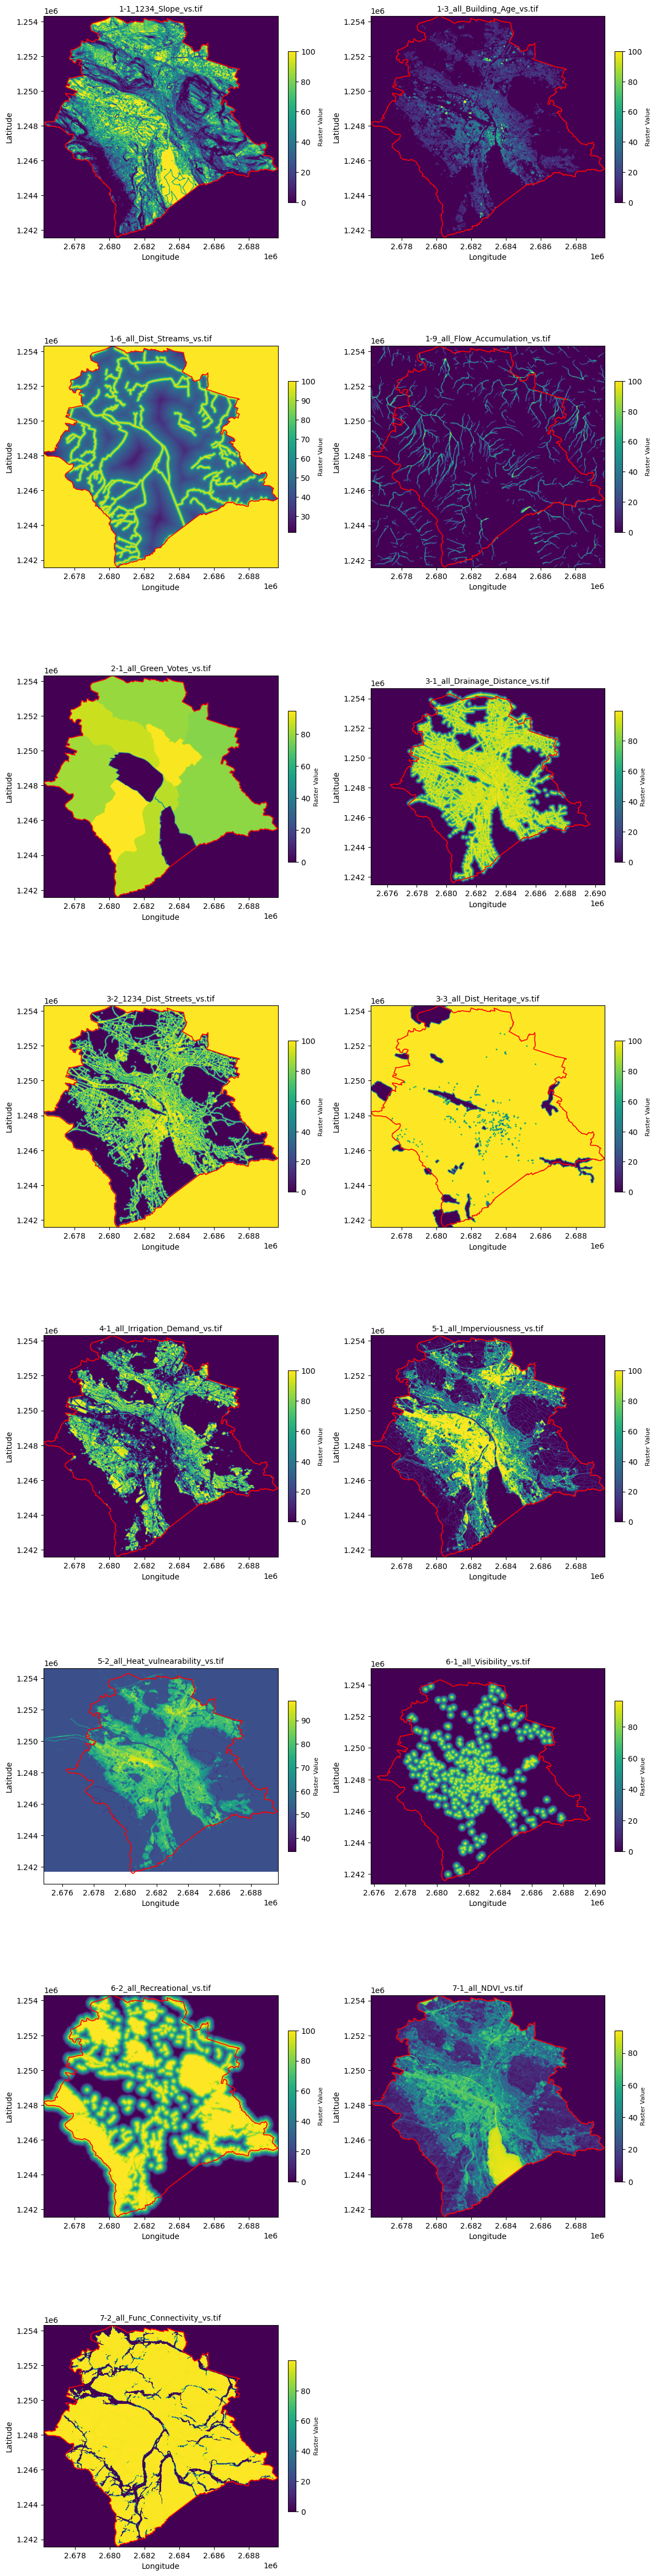

In [41]:

# Parameters
files_to_plot = value_scale_files  # List of all files
num_files = len(files_to_plot)
cols = 2  # Number of columns in the subplot grid
rows = (num_files + cols - 1) // cols  # Calculate rows dynamically

# Create the figure and axes for subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through the files and plot each raster
for idx, file_name in enumerate(files_to_plot):
    with rasterio.open(new_dir + file_name) as src:
        # Read raster data
        raster_data = src.read(1)
        
        # Define raster extent
        extent = [
            src.bounds.left,
            src.bounds.right,
            src.bounds.bottom,
            src.bounds.top
        ]

        # Reproject city_gdf to match raster CRS
        city_gdf.to_crs(src.crs, inplace=True)
        
        # Plot raster on the corresponding subplot
        ax = axes[idx]
        im = ax.imshow(raster_data, cmap='viridis', extent=extent, origin='upper')
        
        # Plot city boundary
        city_gdf.boundary.plot(ax=ax, color='red', linewidth=1.2, label="City Boundary")
        
        # Set title for each subplot
        ax.set_title(f"{file_name}", fontsize=10)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
        cbar.set_label('Raster Value', fontsize=8)
        
# Remove empty subplots if files < total grid spaces
for i in range(len(files_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


# Plot Map Images

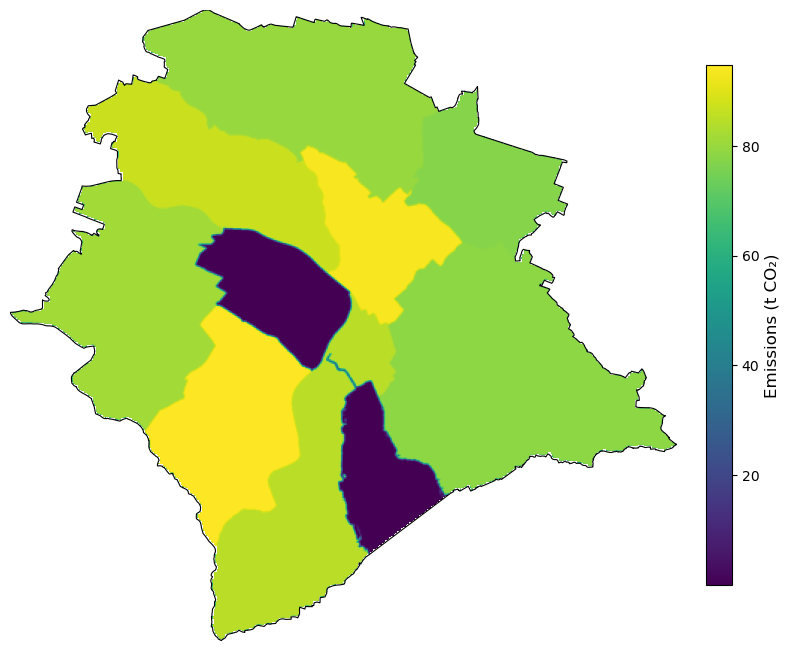

In [72]:
file_num = 4
# Plotting the raster with better formatting

with rasterio.open(new_dir + value_scale_files[file_num]) as src:
    # Mask the raster using city_gdf geometry
    masked_raster, mask_transform = mask(
        src,
        city_gdf.geometry,
        crop=False,
        nodata=np.nan
    )
    
    # Set up the plot with enhanced styles
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size for balance

    # Plot the raster with gray colormap
    im = ax.imshow((masked_raster[0] + 0.01), cmap='viridis', extent=extent)

    # Add city boundary
    city_gdf.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Remove grid, axes labels, and ticks
    ax.axis('off')

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
    cbar.set_label('Emissions (t CO₂)', fontsize=12)

    plt.savefig(f'../Figures/{value_scale_files[file_num]}.png')
    # Save the figure
    plt.tight_layout()
    plt.show()


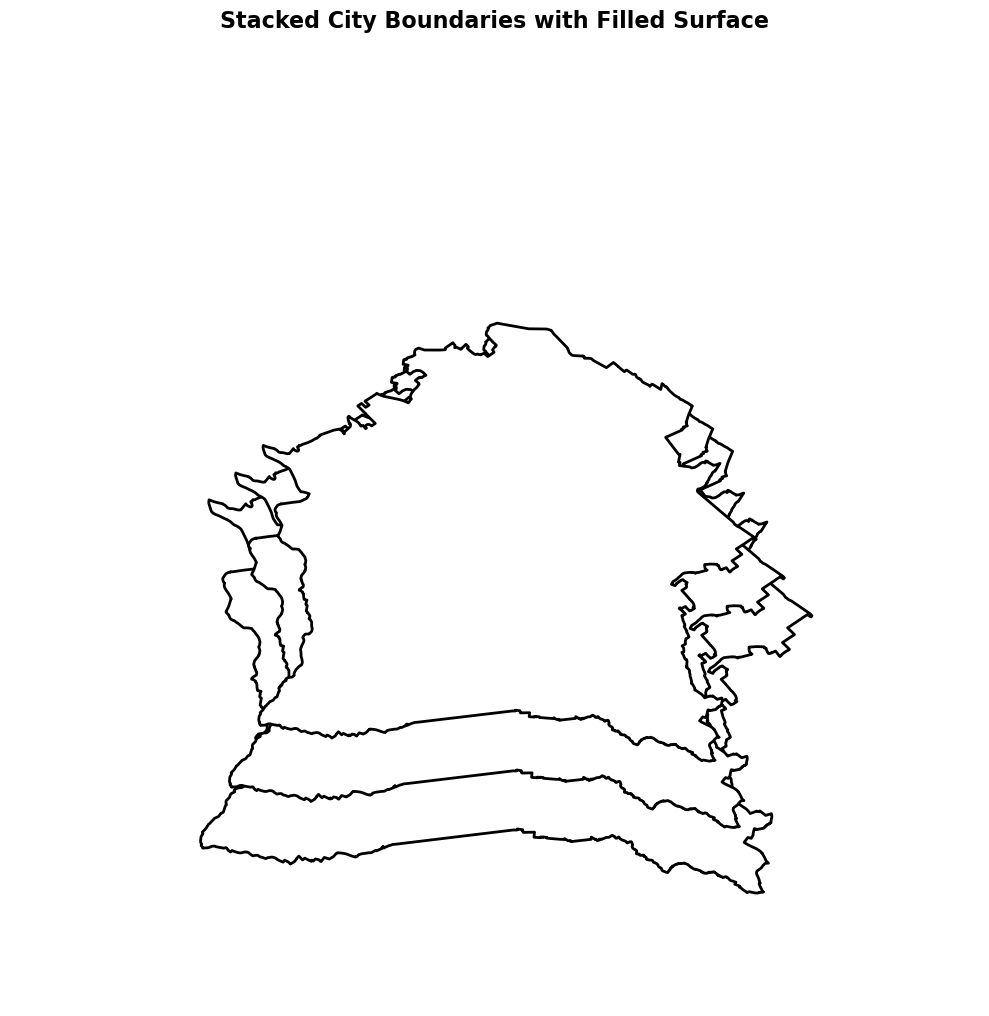

In [75]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon
from shapely.affinity import translate, scale

# Create a 3D figure
fig = plt.figure(figsize=(10, 14))
ax = fig.add_subplot(111, projection='3d')

# Number of layers to stack
num_layers = 3

# Define offsets and scaling for each layer
z_offsets = np.linspace(0, 0.05, num_layers)  # Reduced Z-axis offsets for layers
scales = np.linspace(1, 0.8, num_layers)  # Slightly smaller scaling for each layer

# Loop through each layer
for i, z in enumerate(z_offsets):
    # Scale and translate the geometry for each layer
    scaled_gdf = city_gdf.copy()
    scaled_gdf['geometry'] = scaled_gdf['geometry'].apply(
        lambda geom: translate(scale(geom, xfact=scales[i], yfact=scales[i], origin='center'),
                               xoff=0, yoff=0)
    )

    for geom in scaled_gdf.geometry:
        if isinstance(geom, Polygon):
            # Extract exterior coordinates
            x, y = geom.exterior.xy
            verts = [list(zip(x, y, [z] * len(x)))]  # Create vertices for 3D polygon

            # Add the filled surface
            poly = Poly3DCollection(verts, facecolor='white', edgecolor='black', linewidth=2)  # Thicker border
            ax.add_collection3d(poly)

# Adjust the Z-axis limit
ax.set_zlim(0, 0.15)  # Compress the Z-axis to bring layers closer visually

# Adjust aspect ratio for Z-axis compression
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.3, 1]))

# Customize the 3D plot
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Height (Z Axis)")
ax.set_title("Stacked City Boundaries with Filled Surface", fontsize=16, weight='bold')
ax.grid(False)
ax.axis('off')

# Set the viewing limits
ax.set_xlim(scaled_gdf.total_bounds[0], scaled_gdf.total_bounds[2])
ax.set_ylim(scaled_gdf.total_bounds[1], scaled_gdf.total_bounds[3])
ax.set_zlim(0, max(z_offsets))

# Adjust the camera angle
ax.view_init(elev=50)


# Save the figure
plt.tight_layout()
plt.savefig("stacked_3d_filled_boundaries.png", dpi=300, bbox_inches='tight')
plt.show()
